# Salary Classifier

###  Importing the important libraries

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

### Reading in the dataset using pandas:

In [125]:
df=pd.read_csv("adult.csv")

### Having a look at the data::

In [126]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## EXPLORATORY DATA ANALYSIS::

In [127]:
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'salary'],
      dtype='object')


### CHECKING for duplicte rows::

In [128]:
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape[0])

Number of duplicate rows ::  24


In [129]:
df.drop_duplicates(inplace=True)

### CHECKING for duplicte rows again::

In [130]:
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape[0])

Number of duplicate rows ::  0


### Checking for missing values with different ways:

In [131]:
missing=df.isna().sum()
print(missing)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
country           0
salary            0
dtype: int64


### Handling the '?' signs to replace them with np.nan values

In [132]:
def checkMiss(s):
    if '?' in str(s):
        return None
    elif type(s)==str:
        return s.strip()
    else:
        return s
df=df.applymap(checkMiss).copy()
print(df['occupation'].value_counts())


Prof-specialty       4136
Craft-repair         4094
Exec-managerial      4065
Adm-clerical         3768
Sales                3650
Other-service        3291
Machine-op-inspct    2000
Transport-moving     1597
Handlers-cleaners    1369
Farming-fishing       992
Tech-support          927
Protective-serv       649
Priv-house-serv       147
Armed-Forces            9
Name: occupation, dtype: int64


### checking for missing values again:

In [133]:

missing_cols=[]
missing=df.isna().sum()
for x in missing.index:
    if missing[x]>0:
        missing_cols.append(x)
print(missing_cols)

['workclass', 'occupation', 'country']


### Plotting a heatmap to better visualize missing values:

<AxesSubplot:>

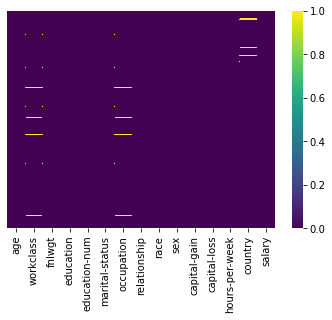

In [134]:

sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')

In [135]:
## Since all the columns which actually have missing values have very few missing values comapred to the number of rows
## Replacement of the missing values is suitable here.
## Using Random Forest Classifier to predict missing values:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

## creating te nomial variables and categorical variales:

categories=[]
for x in df.dtypes.index:
    if df.dtypes[x]=='object':
        categories.append(x)
print(categories)

## categories with ordinal relation:
nominal=['education']
for x in nominal:
  categories.remove(x)
print(categories)
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'country', 'salary']
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'country', 'salary']


In [136]:

## Random Forest Classifier for predicting missing values
## To predict each coulmn's missing values ,we're only gonna use the columns with no missing values:

for x in missing_cols:
    del_list=list(missing_cols)
    
    use=list(categories)
    for k in del_list:
        use.remove(k)
        
    del_list.remove(x)
    df2=df.copy()
    df2.drop(del_list,axis=1,inplace=True)
    df2.dropna(subset=[x],inplace=True)
    
    enc_df = pd.get_dummies(df2,columns=use)
    
    ## handling the nominal variables:
    enc_df['education']=lb.fit_transform(enc_df['education'])
    
    ## fitting the model:
    clf.fit(enc_df.drop(x,axis=1),enc_df[x])
    
    # predicting the missing values from the model:
    df3=df.copy()
    df3.drop(del_list,axis=1,inplace=True)
    df3=pd.get_dummies(df3,columns=use)
    df3['education']=lb.fit_transform(df3['education'])
    df3=df3.loc[df3[x].isna()]
    predictions=clf.predict(df3.drop(x,axis=1))
    target=(df[df[x].isna()][x])
    i=0
    for t in target.index:
        df.at[t,x]=predictions[i]
        i+=1

### Checking for null values again

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
country           0
salary            0
dtype: int64


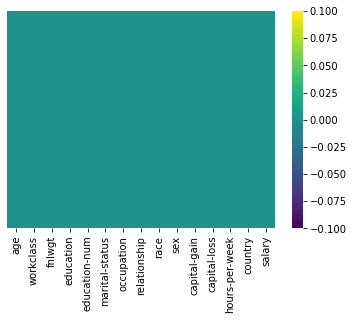

In [137]:

sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')
missing=df.isna().sum()
print(missing)

#### MISSING VALUES HAVE NOW BEEN FIXED

## EXPLORATORY DATA ANALYSIS:
### Checking all the different types of data available::

In [138]:

numerical_=[]
categorical_=[]
for x in df.dtypes.index:
    if df.dtypes[x]=='object':
        categorical_.append(x)
    else:
        numerical_.append(x)
print(categorical_)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'country', 'salary']


### Describing the dataset using describe function:

In [139]:

df.describe(include=['object','int'])

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
count,32537.000000,32537,3.253700e+04,32537,32537.000000,32537,32537,32537,32537,32537,32537.000000,32537.000000,32537.000000,32537,32537
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,24340,NaN,10494,NaN,14970,4319,13187,27795,21775,NaN,NaN,NaN,29664,24698
mean,38.585549,NaN,1.897808e+05,NaN,10.081815,NaN,NaN,NaN,NaN,NaN,1078.443741,87.368227,40.440329,NaN,NaN
std,13.637984,NaN,1.055565e+05,NaN,2.571633,NaN,NaN,NaN,NaN,NaN,7387.957424,403.101833,12.346889,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.369930e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


### Builing a co-relation heatmap for numerical variables:

<AxesSubplot:>

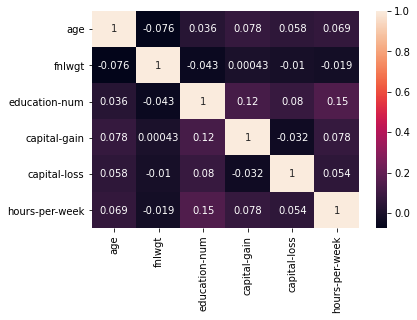

In [140]:

sns.heatmap(df.corr(),annot=True)

### Checking the independent vairables which have high correlation

In [148]:
def correlation(dataset, threshold):
    col_corr=set()
    corr_matrix=dataset.corr()
    print(corr_matrix.columns)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                col_name=corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr

## Checking the inter-relation strengths between numerical variable by using a threshold of 0.85:
res_cols=correlation(df,0.85)
print(res_cols)
for x in df.corr().columns:
    print(x,df[x].max(),df[x].min())

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')
set()
age 90 17
fnlwgt 415706.0 12285.0
education-num 16 1
capital-gain 99999 0
capital-loss 4356 0
hours-per-week 99 1


#### Clearly There are no independent numerical variables to be dropped according to the co-relation heatmap 

## Univariate analysis::
### Building histograms for categorical data:

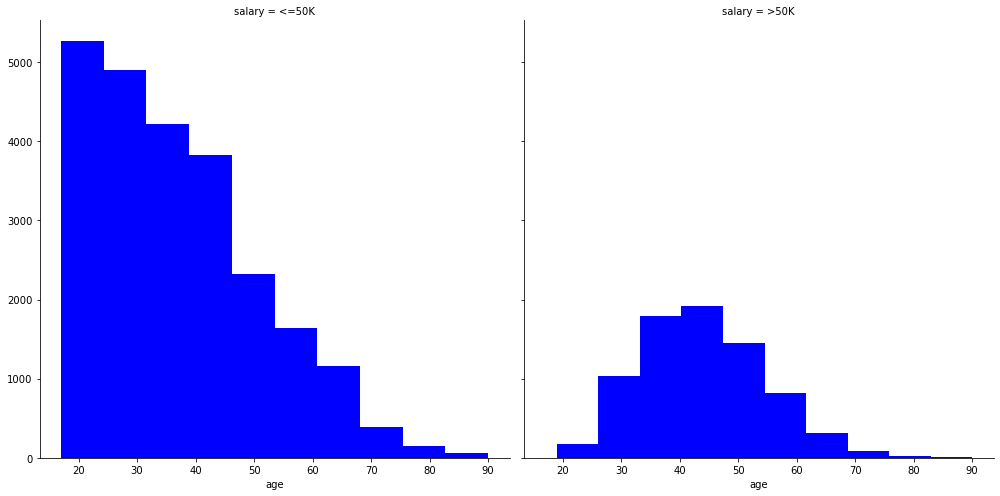

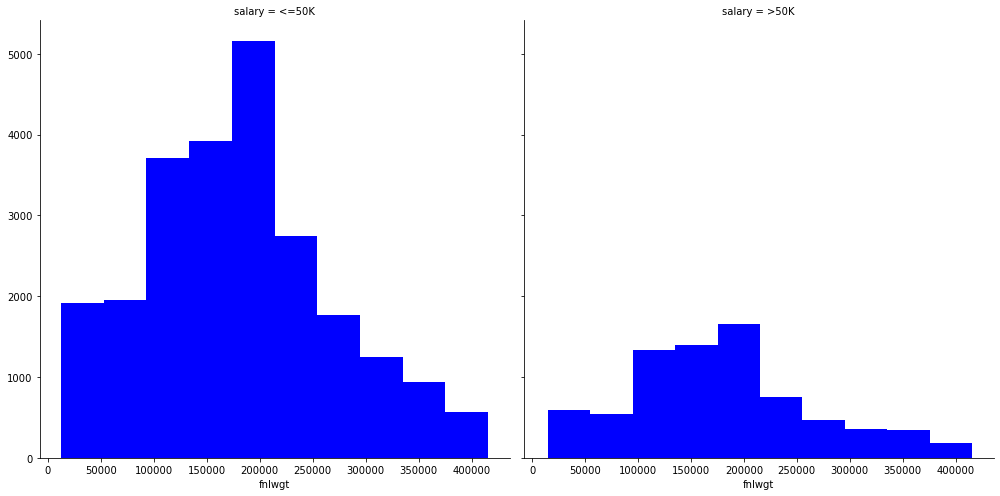

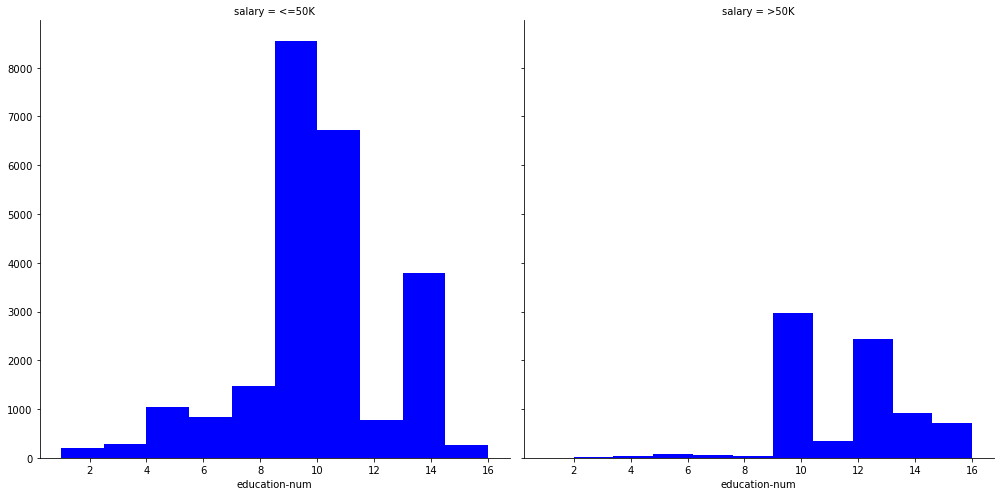

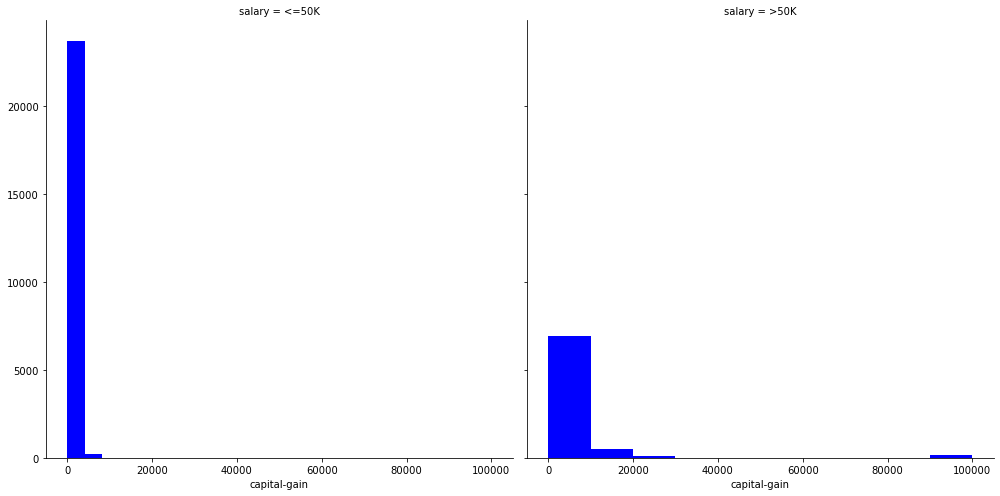

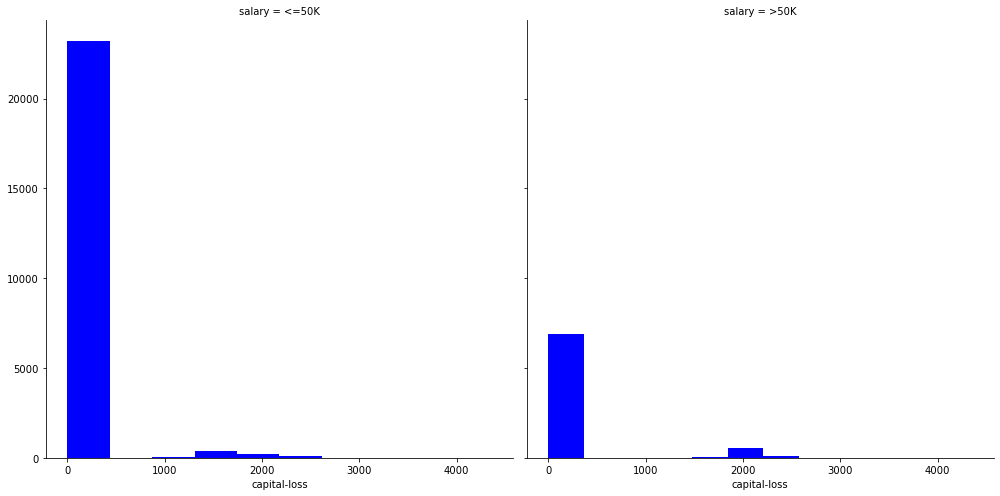

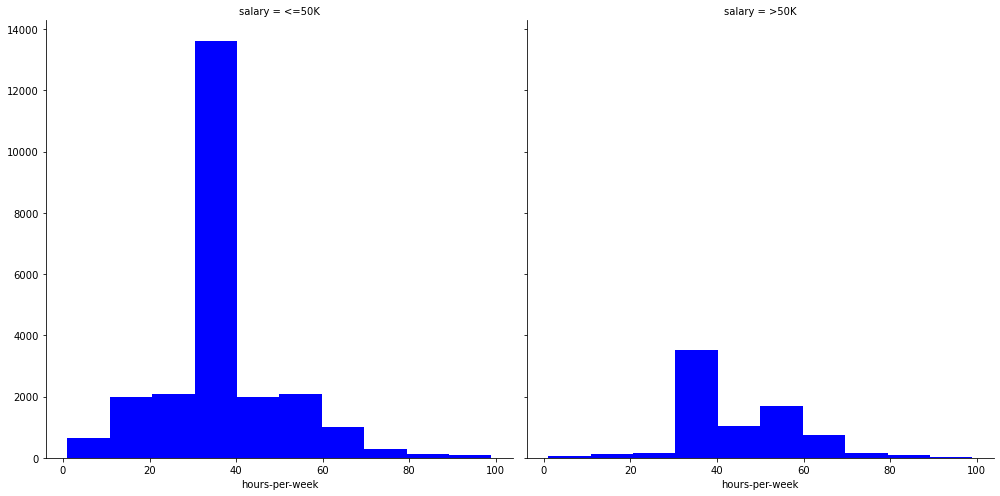

In [149]:
for x in numerical_:
    sns.FacetGrid(df,col=df.columns[-1],height=7).map(plt.hist,x,color='blue')

## Countplots for categorical variables:

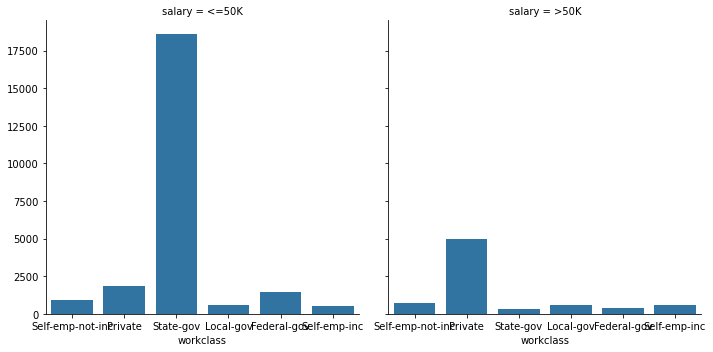

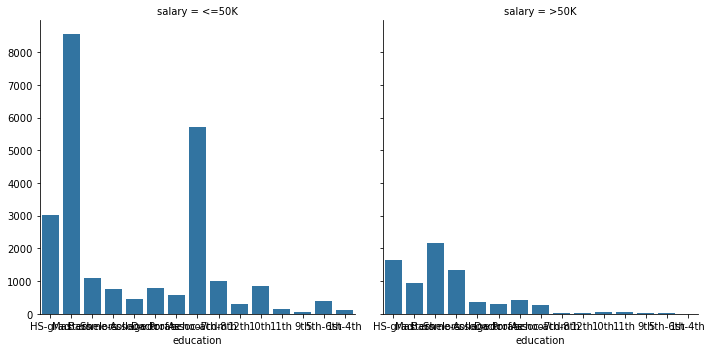

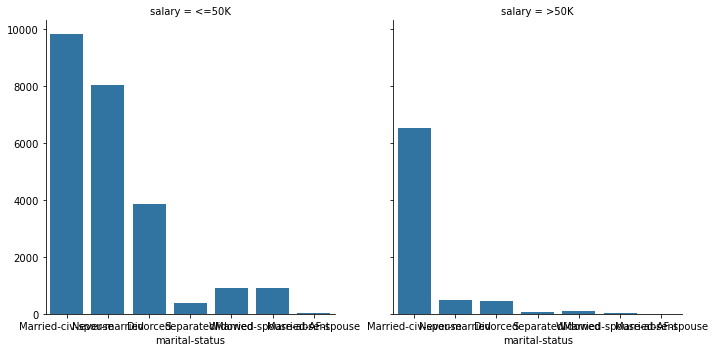

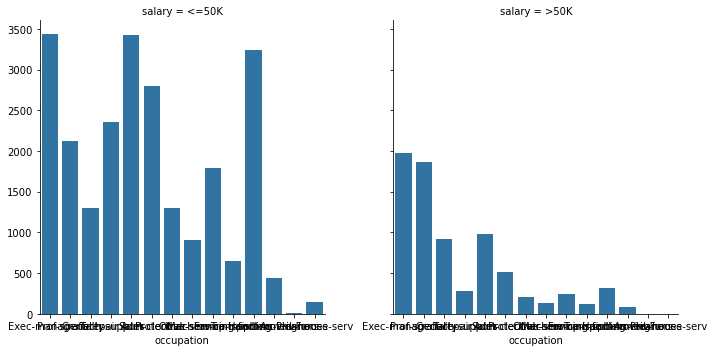

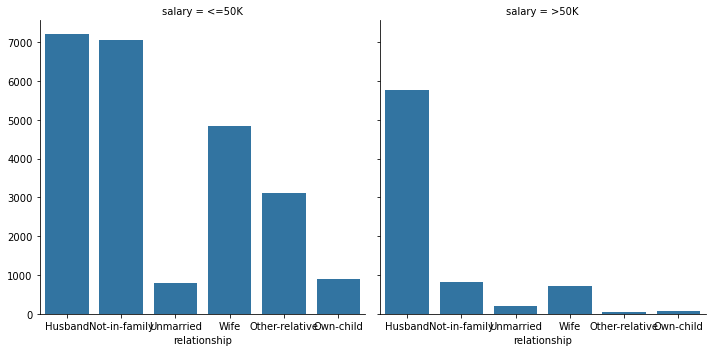

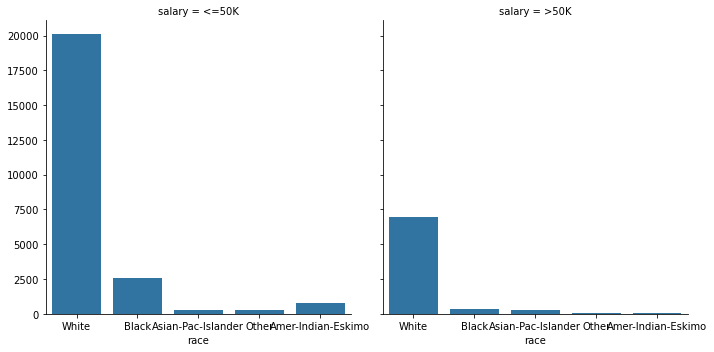

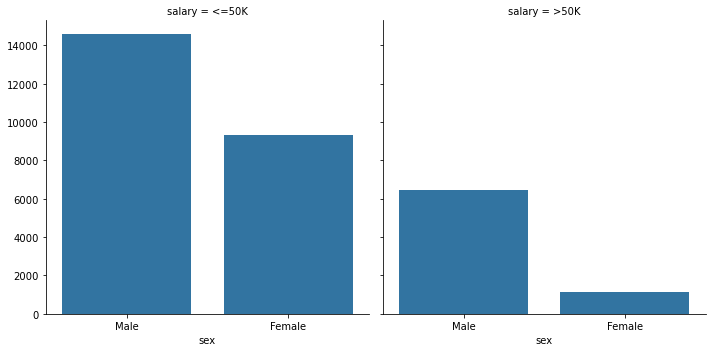

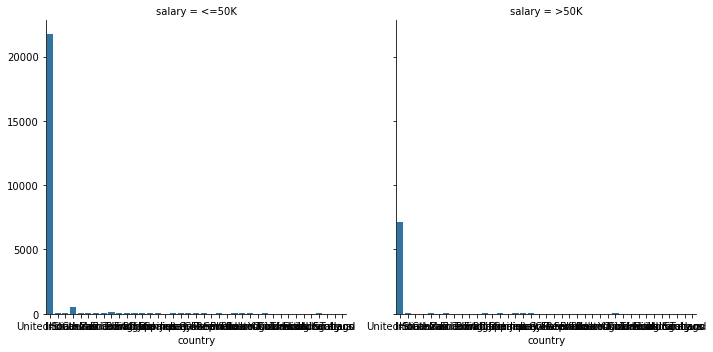

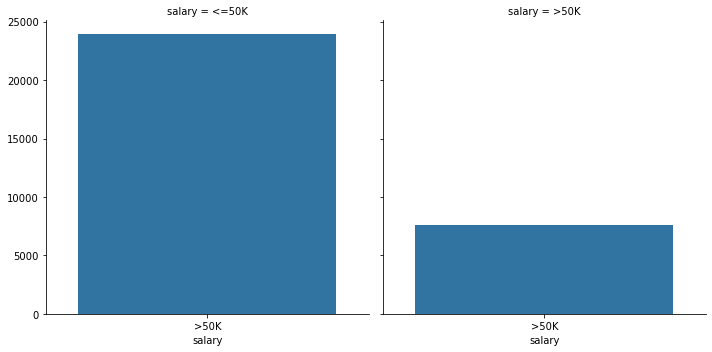

In [150]:
for x in categorical_:
  sns.FacetGrid(df,col=df.columns[-1],height=5).map(sns.countplot,x)  

### Building countplots for categorical variables:

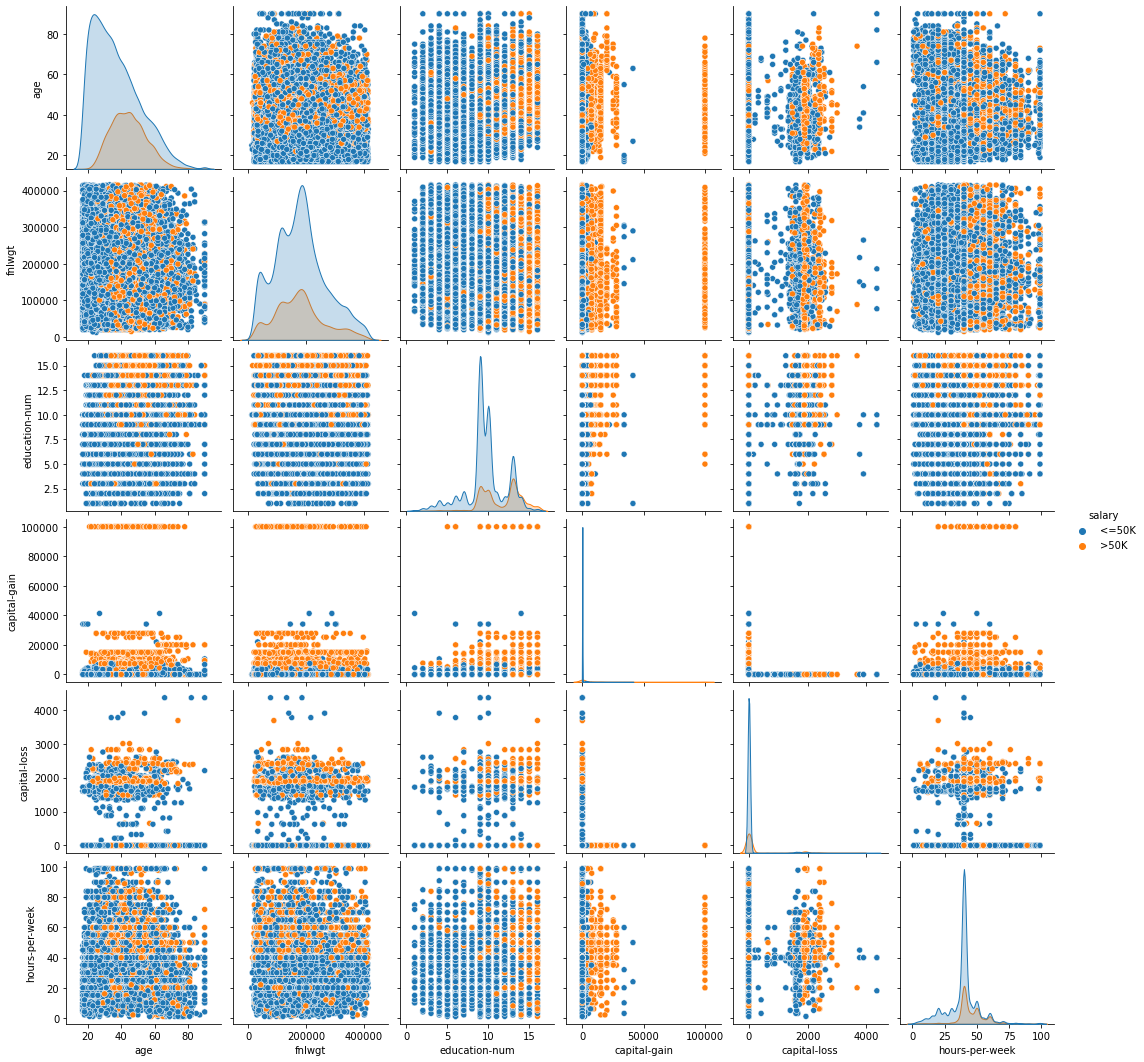

In [151]:
sns.pairplot(df,hue='salary')

### Since points are not linearly seperable, it would be appropriate to not use Logistic Regression

### Feature selection for numerical features using ONE WAY ANOVA:

In [152]:
from sklearn.feature_selection import f_classif


p_vals=f_classif(df[numerical_],df['salary'])[1]

# P-vals less than 0.05( ones which are important)
# Dropping the numerical variables which are'nt important according to one way ANOVA:
numerical_drop=np.array(numerical_)[p_vals>0.05]

# columns dropped:
print(numerical_drop)
df.drop(numerical_drop,axis=1,inplace=True)



['fnlwgt']


### Feature selection for categorical features:

In [153]:
## Making a copy of the dataframe and modifying it for perforiming a chi sqaure test:

bf=df.copy()
for x in categorical_:
    dik={k:i for i,k in enumerate(bf[x].unique())}
    bf[x]=bf[x].map(dik)
print(bf.head())

   age  workclass  education  education-num  marital-status  occupation  \
0   39          0          0             13               0           0   
1   50          1          0             13               1           1   
2   38          2          1              9               2           2   
3   53          2          2              7               1           2   
4   28          2          0             13               1           3   

   relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
0             0     0    0          2174             0              40   
1             1     0    0             0             0              13   
2             0     0    0             0             0              40   
3             1     1    0             0             0              40   
4             2     1    1             0             0              40   

   country  salary  
0        0       0  
1        0       0  
2        0       0  
3        0       0  

### Chi square (for checking which categorical vairables could be dropped):

In [154]:

from sklearn.feature_selection import chi2
kf=bf[categorical_]
kf=kf.drop('salary',axis=1)
f_p_vals=chi2(kf,bf['salary'])

## checking p-values at 0.05 significance:
remove_cols=[]
ser=pd.Series(f_p_vals[1])
ser.index=kf.columns
for x in ser.index:
    if ser[x]>0.05:
        remove_cols.append(x)
        print('Remove the feature ::',x)
        
## removing the unimportant columns from DF:
df.drop(remove_cols,axis=1,inplace=True)


## FEATURE ENGINEERING:

In [155]:


## converting ordinal categorical data to numerical:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
df['education']=lb.fit_transform(df['education'])

## Removing the unwanted features according to the chi sqaure test:
categorical_.remove('marital-status')


## features with high cardinality:
high_card=['country','occupation','salary']
low_card=list(set(categorical_)-set(high_card))
low_card.remove('education')

## converting non-ordinal categorical(low_cardinaility) data to numerical:
df=pd.get_dummies(df,columns=low_card)

In [156]:
print(df.head())

   age  education  education-num      marital-status         occupation  \
0   39          9             13       Never-married       Adm-clerical   
1   50          9             13  Married-civ-spouse    Exec-managerial   
2   38         11              9            Divorced  Handlers-cleaners   
3   53          1              7  Married-civ-spouse  Handlers-cleaners   
4   28          9             13  Married-civ-spouse     Prof-specialty   

   capital-gain  capital-loss  hours-per-week        country salary  ...  \
0          2174             0              40  United-States  <=50K  ...   
1             0             0              13  United-States  <=50K  ...   
2             0             0              40  United-States  <=50K  ...   
3             0             0              40  United-States  <=50K  ...   
4             0             0              40           Cuba  <=50K  ...   

   relationship_Own-child  relationship_Unmarried  relationship_Wife  \
0                   

In [157]:
## converting non-ordinal categorical(high_cardinaility) data to numerical:
val_count1=df.occupation.value_counts().to_dict()
val_count2=df.country.value_counts().to_dict()
df.occupation=df.occupation.map(val_count1)
df.country=df.country.map(val_count2)
print(df.head())


   age  education  education-num      marital-status  occupation  \
0   39          9             13       Never-married        3941   
1   50          9             13  Married-civ-spouse        4094   
2   38         11              9            Divorced        1381   
3   53          1              7  Married-civ-spouse        1381   
4   28          9             13  Married-civ-spouse        4213   

   capital-gain  capital-loss  hours-per-week  country salary  ...  \
0          2174             0              40    28829  <=50K  ...   
1             0             0              13    28829  <=50K  ...   
2             0             0              40    28829  <=50K  ...   
3             0             0              40    28829  <=50K  ...   
4             0             0              40       94  <=50K  ...   

   relationship_Own-child  relationship_Unmarried  relationship_Wife  \
0                       0                       0                  0   
1                       0 

# Model Selection:

### Using xgboost with hyper-parameter tuning::

In [162]:
import xgboost
df=df.drop('marital-status',axis=1)

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
params={
    "learning_rate": [0.05,0.10,0.15,0.2],
    "max_depth":[3,4,5,6],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3]
}

In [164]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop('salary',axis=1),df['salary'],test_size=0.33,stratify=df['salary'])

In [165]:
model = xgboost.XGBClassifier()
rs=RandomizedSearchCV(model,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
rs.fit(xtrain,ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[00:27:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                   

In [166]:
rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [167]:
classy=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [168]:
classy.fit(xtrain,ytrain)

[00:27:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [169]:
pred=classy.predict(xtest)

In [170]:
## Printing accuracy score::
print(accuracy_score(ytest,pred))

0.8714697406340057


### Using decision tree classifier:

In [171]:

from sklearn.tree import DecisionTreeClassifier

clf=DecisionTreeClassifier()
clf.fit(xtrain,ytrain)

DecisionTreeClassifier()

In [172]:
pred=clf.predict(xtest)
print(accuracy_score(pred,ytest))

0.8198847262247838


### Using CCP_alpha hyper-parameter tuning:

In [173]:

path=clf.cost_complexity_pruning_path(xtrain,ytrain)
ccp_alphas,impurities=path.ccp_alphas,path.impurities
ccp_alphas


array([0.        , 0.        , 0.        , ..., 0.02059292, 0.02586501,
       0.05961158])

In [ ]:
## storing all decision trees with different ccp_alpha value::
clfs=[]
for ccp_alpha in ccp_alphas:
    clf=DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(xtrain,ytrain)
    clfs.append(clf)

In [ ]:
train_scores=[clf.score(xtrain,ytrain) for clf in clfs]
test_scores=[clf.score(xtest,ytest) for clf in clfs]


In [ ]:
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Accuracy vs Alpha')
plt.plot(ccp_alphas,train_scores,marker='o',label='train')
plt.plot(ccp_alphas,test_scores,marker='o',label='test')
plt.show()

In [ ]:
clf=DecisionTreeClassifier(ccp_alpha=0.002)
clf.fit(xtrain,ytrain)
pred=clf.predict(xtest)
print(accuracy_score(pred,ytest))

### Applying KNN:

In [ ]:

from sklearn.preprocessing import StandardScaler        
from sklearn.neighbors import KNeighborsClassifier
# define min max scaler
scaler = StandardScaler()
# fit and transform train data
scaled = scaler.fit_transform(xtrain)
## Transform testing data:
final_test=scaler.transform(xtest)

# AApplying KNN:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(scaled,ytrain)

pred=knn.predict(final_test)
accuracy=accuracy_score(pred,ytest)
accuracy

#### Applying KNN with Hyper-parameter tuning:

In [ ]:

k_vals=[x for x in range(50)]
params={'n_neighbors': k_vals}
knn=KNeighborsClassifier()
rs=RandomizedSearchCV(knn,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
rs.fit(xtrain,ytrain)

In [ ]:
rs.best_estimator_

In [ ]:
knn=KNeighborsClassifier(n_neighbors=22)

In [ ]:
knn.fit(scaled,ytrain)

pred=knn.predict(final_test)
accuracy=accuracy_score(pred,ytest)
accuracy

## Applying Random Forests:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()

In [ ]:
model.fit(xtrain,ytrain)

In [ ]:
pred=model.predict(xtest)

In [ ]:
print(accuracy_score(pred,ytest))

In [ ]:
print(model.get_params())

## Applying random forests with hyper parameter tuning :


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Create the parameter grid based on the results of random search 
random_grid = {
    'bootstrap': [True,False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4, 5, 6 ,7 ,8 ,9, 10],
    'min_samples_leaf': [1,2,3, 4, 5],
    'min_samples_split': [2,3,4,5,7,9],
    'n_estimators': [100, 200, 300, 1000]
}
rfc=RandomForestClassifier()
rf_random =RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(xtrain,ytrain)

In [ ]:
rf_random.best_estimator_

In [ ]:
rfc=RandomForestClassifier(bootstrap=False, max_depth=90, max_features=4,
                       min_samples_leaf=4, min_samples_split=9,
                       n_estimators=300)
rfc.fit(xtrain,ytrain)

In [ ]:
pred=rfc.predict(xtest)

In [ ]:
print(accuracy_score(pred,ytest))

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [80]:

print(recall_score(pred,ytest,average=None))
print(f1_score(pred,ytest,average=None))

[0.88345736 0.78332501]
[0.91401161 0.68366013]
